# Configuración inicial y librerías

Se importan las librerías necesarias para llevar a cabo el preprocesamiento del dataset. Este conjunto de datos requiere transformación de fechas, codificación de variables categóricas, creación de nuevas características y manejo de valores faltantes. A continuación, se explican brevemente las librerías utilizadas:

- `polars`: manipulación de datos estructurados, se emplea polars en lugar de pandas para optimizar el uso de recursos computacionales.
- `numpy`: operaciones numéricas y matemáticas.
- `scipy.stats`: operaciones estadísticas como la moda.
- `sklearn.preprocessing.LabelEncoder`: codificación de variables categóricas.
- `matplotlib.pyplot`: visualización básica (opcional).
- `warnings`: suprime advertencias innecesarias en la ejecución.
- `gc` (garbage collector): optimiza el uso de memoria.



In [88]:
# Librerías
import polars as pd
import numpy as np
import seaborn as sns
import scipy.stats
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import warnings
import gc

# Ignorar advertencias

warnings.filterwarnings("ignore")

# Activar garbage collector para habilitar la recoleccion de basura, esto mejora el rendimiento en ambientes 
# que tienen un uso intensivo de memoria como lo es el caso del manejo de los datasets de la actividad desarrollada

gc.enable()


# Pre-preprocesamiento de datos

### Convertir unidades (dias)
La función `convertir_dias(data, columnas, divisor=12, redondear=True, reemplazar=False)` se utiliza para transformar columnas que contienen valores de tiempo expresados en días negativos, como por ejemplo DAYS_BIRTH o DAYS_EMPLOYED se pasa de dias negativos a meses.

El parámetro columnas especifica la lista de variables que se desean transformar. El parámetro `divisor` determina en qué unidad se hará la conversión (en este caso 12, para convertirlo a meses).

Dentro del bucle, se invierte el signo del valor (porque los días vienen negativos en el dataset), se divide por el `divisor`. Luego, se eliminan los valores negativos resultantes, ya que estos suelen ser errores de codificación y se reemplazan por None.

In [89]:
def convertir_dias(data, columnas, divisor=12, redondear=True, reemplazar=False):
    columnas_existentes = [col for col in columnas if col in data.columns]
    nuevas_columnas = []

    for col in columnas_existentes:
        expr = -(pd.col(col) / divisor)

        if redondear:
            expr = expr.round()

        expr = expr.map_elements(lambda x: None if x < 0 else x).alias(col if reemplazar else f"CONVERTIDO_{col}")
        nuevas_columnas.append(expr)

    return data.with_columns(nuevas_columnas)


### Crear variables logarítmicas
La función `crear_logaritmos(data, columnas, reemplazar=False)` se utiliza para aplicar una transformación logarítmica a las variables numéricas del dataset. Este tipo de transformación es común cuando se trabaja con variables como ingresos, montos de crédito, etc. Esto se debe a que las transformaciones logarítmicas pueden ayudar a corregir la asimetría de variables y mejorar la linealidad en modelos estadísticos.

In [90]:
def crear_logaritmos(data, columnas, replace=False):
    nuevas_columnas = []
    for col in columnas:
        log_col = pd.col(col).abs().add(1).log().alias(col if replace else f"LOG_{col}")
        nuevas_columnas.append(log_col)
    
    return data.with_columns(nuevas_columnas)


### Codificar variables categóricas
Mucha de la información que se tiene del dataset son string o cadenas de texto que el modelo no va a poder interpretar por si solo, se crea la funcion `tratar_categoricas(data)` para que a cada columna que tenga valores de tipo objeto se le reemplace cada categoria por un valor entero unico.
Por ejemplo en la columna `GENRE` se remplazaria ``M`` por 0 y ``F`` por 1

In [91]:
#Codifica todas las variables categóricas del DataFrame usando codificación por etiquetas.
#Cada categoría única se reemplaza por un número entero único.
def tratar_categoricas(data):
    columnas_obj = [col for col in data.columns if data[col].dtype == pd.String]
    nuevas_columnas = []

    for col in columnas_obj:
        # Encodear con "categorical().to_physical()" convierte a entero único por categoría
        expr = pd.col(col).cast(pd.Categorical).to_physical().alias(col)
        nuevas_columnas.append(expr)

    return data.with_columns(nuevas_columnas)


# Preprocesamiento de los datos

### Contar valores nulos
La función `contar_nulos(data)` permite encontrar valores faltantes en un conjunto de datos. Su objetivo es identificar qué columnas tienen datos incompletos, cuántos valores faltan y qué porcentaje representan respecto al total de registros.

Primero, calcula la cantidad total de valores nulos en cada columna utilizando `data.isnull().sum()`, que cuenta los `True` para cada celda nula. Luego, ordena estas cantidades de forma descendente para priorizar las columnas más problemáticas.

A continuación, calcula el porcentaje de nulos dividiendo cada total de nulos por el número total de filas del `DataFrame`, y multiplica por 100 para expresarlo en porcentaje. También se ordenan los resultados de mayor a menor.

Ambas series (total y porcentaje) se combinan en un solo `DataFrame` usando `pd.concat.

Por último, se filtran las columnas con valores nulos, devolviendo únicamente aquellas que presentan al menos un valor faltante. Esto permite enfocarse exclusivamente en las variables que requieren algún tipo de tratamiento durante la limpieza de datos.

In [92]:
def contar_nulos(data):
    # Contar los valores nulos por columna
    total = data.select([pd.col(col).is_null().sum().alias(col) for col in data.columns])
    
    # Calcular el porcentaje de valores nulos
    porcentaje = data.select([((pd.col(col).is_null().sum() / data.height) * 100).cast(pd.Float64).alias(col) for col in data.columns])
    return porcentaje


### Calcular tasas de aprobación y rechazo
Despues de realizar una busqueda sobre modelos de riesgo crediticio se encontro que los modelos de crédito deben de considerar el historial de comportamiento previo como uno de los predictores más potentes.

Esto se puede encontrar en Basel Committee on Banking Supervision — Credit Risk Modelling: Current Practices and Applications (https://www.bis.org/publ/bcbs49.htm) donde se menciona expresamente el uso de variables como el comportamiento pasado del cliente como feature principal o en Anderson, R. (2007). The Credit Scoring Toolkit: Theory and Practice for Retail Credit Risk Management (mirar capitulo 9) donde se menciona que variables como número de rechazos previos, historial de solicitudes y frecuencia de aceptación son claves para desarrollar un analisis completo.

Se procede a construir la funcion `calcular_ratio_aprobacion(data, lags=[1, 2, 5])` que tiene como objetivo calcular, para cada cliente ``(SK_ID_CURR)``, el porcentaje de solicitudes aprobadas y rechazadas en sus últimas t solicitudes de crédito, donde t toma los valores definidos en la lista lags (para este caso elegi los valores: [1, 2, 5]).

se crearan las columnas "RATIO_APROBADO_{t}" donde RATIO_APROBADO_1 es si la ultima solicitud fue aprobada y RATIO_APROBADO_2 es cuántas de las 2 más recientes fueron rechazadas, en promedio. Exactamente lo mismo para el ratio de rechazo

In [93]:
def calcular_ratio_aprobacion(data, lags=[1, 2, 5]):
    #Se extraen solo las columnas necesarias
    df = data[["SK_ID_CURR", "SK_ID_PREV", "DAYS_DECISION", "NAME_CONTRACT_STATUS"]]
    #La columna DAYS_DECISION representa la antigüedad de la solicitud (en días negativos). 
    #Se invierte el signo para que los valores más recientes queden al final, y se ordena por cliente y fecha.
    df["DAYS_DECISION"] = -df["DAYS_DECISION"]
    df = df.sort_values(["SK_ID_CURR", "DAYS_DECISION"])
    #Se aplican dummies sobre la columna NAME_CONTRACT_STATUS para generar columnas binarias como: 1 aprobado o 0 rechazado
    df = pd.get_dummies(df)

    for t in lags:
        tmp = df.groupby("SK_ID_CURR")["NAME_CONTRACT_STATUS_Approved"].head(t).groupby("SK_ID_CURR").mean().reset_index()
        tmp.columns = ["SK_ID_CURR", f"RATIO_APROBADO_{t}"]
        data = data.merge(tmp, on="SK_ID_CURR", how="left")

        tmp = df.groupby("SK_ID_CURR")["NAME_CONTRACT_STATUS_Refused"].head(t).groupby("SK_ID_CURR").mean().reset_index()
        tmp.columns = ["SK_ID_CURR", f"RATIO_RECHAZADO_{t}"]
        data = data.merge(tmp, on="SK_ID_CURR", how="left")

    return data


### Determinar correlacion entre las variables
Una tecnica comun en el preprocesamiento de datos es la reduccion de caracteristicas, esta me dice que si tengo 2 vaiables que tienen una correlacion fuerte (si mi correlacion es igual a 1 entonces son directamente proporcionales y si es -1 son inversamente proporcionales) entonces es redundante tenerlas y puede llegar a dificultar la deteccion de un patron ya que lo que me dice una variable se puede interpretar de la otra. Con esto en mente se procede a calcular la correlacion entre las variables y a eliminar las que estan fuertemente correlacionadas entre si.

In [94]:
import polars as pl
import numpy as np

def eliminar_variables_correlacionadas_polars(df, umbral=0.9, columnas_excluidas=[]):
    # 1. Seleccionar solo las columnas numéricas
    numericas = [col for col, dtype in zip(df.columns, df.dtypes)
                 if dtype in (pl.Float64, pl.Float32, pl.Int64, pl.Int32)]

    # 2. Crear un DataFrame solo con esas columnas
    df_num = df.select(numericas)

    # 3. Convertir a numpy para calcular la matriz de correlación
    corr_np = df_num.to_numpy()
    corr_matrix = np.corrcoef(corr_np, rowvar=False)

    # 4. Crear un heatmap con seaborn
    columnas_a_eliminar = set()
    for i in range(len(corr_matrix)):
        for j in range(i):
            if abs(corr_matrix[i, j]) > umbral:
                colname = df_num.columns[i]
                columnas_a_eliminar.add(colname)

    # Eliminar columnas que están en la lista de eliminación, excluyendo las que deben permanecer
    columnas_a_eliminar = list(set(columnas_a_eliminar) - set(columnas_excluidas))

    # 5. Seleccionar solo las columnas no eliminadas
    df_sin_correlacion = df.select([col for col in df.columns if col not in columnas_a_eliminar])
    
    return df_sin_correlacion, columnas_a_eliminar


### Detección y manejo de valores atipicos
Se debe determinar los valores que se salen del comportamiento normal de la variable, para ello se procedera a ver los valores que son superiores al bigote superior (el bigote superior se calcula como el cuartil 3 + 1.5 * el rango intercuartilico, el rango intercuatilico es la diferencia entre el cuartil 3 y el cuartil 1), y el bigote inferior se calcula como Q1-1.5 * el rango intercuartilico.

Si los valores atipicos representan una gran parte de la poblacion entonces la muestra no tiene una comportamiento normal, para esto se determina si los valores atipicos son menores al 7% (este valor no esta respaldado en la literatura, es una asuncion propia) y en caso de que sea menores al 7% se pueden eliminar sin alterar significativamente el resultado

In [95]:
def eliminar_outliers(df: pd.DataFrame, umbral: float = 0.07, excluir: list[str] = []) -> pd.DataFrame:
    """
    Elimina los outliers por variable numérica si representan menos del 7% de los datos.
    Se pueden excluir columnas específicas del análisis, por ejemplo no tendria sentido calcular los ouliers de los ID.
    """
    df_limpio = df.clone()
    columnas_numericas = [
        col for col, dtype in zip(df.columns, df.dtypes)
        if dtype in (pd.Float32, pd.Float64, pd.Int32, pd.Int64) and col not in excluir
    ]
    total_filas = df.height
    outliers_eliminados = []

    for col in columnas_numericas:
        q1 = df.select(pd.col(col).quantile(0.25, "nearest")).item()
        q3 = df.select(pd.col(col).quantile(0.75, "nearest")).item()
        iqr = q3 - q1
        limite_inferior = q1 - 1.5 * iqr
        limite_superior = q3 + 1.5 * iqr

        outliers = df.filter((pd.col(col) < limite_inferior) | (pd.col(col) > limite_superior))
        porcentaje_outliers = outliers.height / total_filas

        if porcentaje_outliers < umbral:
            df_limpio = df_limpio.filter((pd.col(col) >= limite_inferior) & (pd.col(col) <= limite_superior))
            outliers_eliminados.append(col)
    
    print(f"Outliers eliminados en {len(outliers_eliminados)} columnas: {outliers_eliminados}")
    return df_limpio


### Importar la data

In [96]:
train = pd.read_csv("files/application_train.csv")
test  = pd.read_csv("files/application_test.csv")
previous_application  = pd.read_csv("files/previous_application.csv")
installments  = pd.read_csv("files/installments_payments.csv",ignore_errors=True)

In [97]:
# Extraer la variable objetivo
y = train.select(["SK_ID_CURR", "TARGET"])
train = train.drop("TARGET")
y


SK_ID_CURR,TARGET
i64,i64
100002,1
100003,0
100004,0
100006,0
100007,0
…,…
456251,0
456252,0
456253,0


In [98]:
df_combinado = pd.concat([train, test])
del train, test
df_combinado

SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,…,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
i64,str,str,str,str,i64,f64,f64,f64,f64,str,str,str,str,str,f64,i64,i64,f64,i64,f64,i64,i64,i64,i64,i64,i64,str,f64,i64,i64,str,i64,i64,i64,i64,i64,…,f64,str,str,f64,str,str,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64
100002,"""Cash loans""","""M""","""N""","""Y""",0,202500.0,406597.5,24700.5,351000.0,"""Unaccompanied""","""Working""","""Secondary / secondary special""","""Single / not married""","""House / apartment""",0.018801,-9461,-637,-3648.0,-2120,null,1,1,0,1,1,0,"""Laborers""",1.0,2,2,"""WEDNESDAY""",10,0,0,0,0,…,0.0,"""reg oper account""","""block of flats""",0.0149,"""Stone, brick""","""No""",2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,"""Cash loans""","""F""","""N""","""N""",0,270000.0,1293502.5,35698.5,1.1295e6,"""Family""","""State servant""","""Higher education""","""Married""","""House / apartment""",0.003541,-16765,-1188,-1186.0,-291,null,1,1,0,1,1,0,"""Core staff""",2.0,1,1,"""MONDAY""",11,0,0,0,0,…,0.01,"""reg oper account""","""block of flats""",0.0714,"""Block""","""No""",1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,"""Revolving loans""","""M""","""Y""","""Y""",0,67500.0,135000.0,6750.0,135000.0,"""Unaccompanied""","""Working""","""Secondary / secondary special""","""Single / not married""","""House / apartment""",0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,"""Laborers""",1.0,2,2,"""MONDAY""",9,0,0,0,0,…,null,null,null,null,null,null,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,"""Cash loans""","""F""","""N""","""Y""",0,135000.0,312682.5,29686.5,297000.0,"""Unaccompanied""","""Working""","""Secondary / secondary special""","""Civil marriage""","""House / apartment""",0.008019,-19005,-3039,-9833.0,-2437,null,1,1,0,1,0,0,"""Laborers""",2.0,2,2,"""WEDNESDAY""",17,0,0,0,0,…,null,null,null,null,null,null,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null,null,null,null,null,null
100007,"""Cash loans""","""M""","""N""","""Y""",0,121500.0,513000.0,21865.5,513000.0,"""Unaccompanied""","""Working""","""Secondary / secondary special""","""Single / not married""","""House / apartment""",0.028663,-19932,-3038,-4311.0,-3458,null,1,1,0,1,0,0,"""Core staff""",1.0,2,2,"""THURSDAY""",11,0,0,0,0,…,null,null,null,null,null,null,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,

Se eliminan las columnas que desde el analisis preliminar se determina que no brindan informacion relevante para el analisis.
Si se desea mas detalle de por que se descartaron leer el archivo README.md

In [99]:
columnas_no_relevantes=['APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 
         'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
         'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI','YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
         'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'COMMONAREA_MODE','ELEVATORS_MODE', 'ENTRANCES_MODE', 
         'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 
         'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'TOTALAREA_MODE',  'YEARS_BEGINEXPLUATATION_MODE','NAME_TYPE_SUITE', 
         'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 
         'FLAG_PHONE', 'FLAG_EMP_PHONE']

df_combinado = df_combinado.drop(columnas_no_relevantes)

### Columnas que pueden resstructurarse de una mejor manera
Hay varios campos que no me dan información significativa de manera individual pero se puede generar un nuevo campo calculado que resuma varias columnas, por ejemplo son 20 columnas que dan informacion sobre si el cliente entrego un documento X, seria mas practico resumir esas 20 columnas en una sola para evaluar cuantos de esos documentos se entregaron con respecto al total de documentos. Ademas podria sacar otra columna como el ingreso por hogar al dividir los ingresos que tiene una persona por el numero de personas que viven en su hogar "CNT_FAM_MEMBERS" y de esta forma elimino "CNT_FAM_MEMBERS".

In [100]:
df_combinado = df_combinado.with_columns([
    (pd.col("AMT_INCOME_TOTAL") / pd.col("CNT_FAM_MEMBERS")).alias("INGRESO_POR_PERSONA")
]).drop(["CNT_FAM_MEMBERS"])


In [101]:
docs = [
    "FLAG_DOCUMENT_2",  "FLAG_DOCUMENT_3",  "FLAG_DOCUMENT_4",  "FLAG_DOCUMENT_5",  "FLAG_DOCUMENT_6",
    "FLAG_DOCUMENT_7",  "FLAG_DOCUMENT_8",  "FLAG_DOCUMENT_9",  "FLAG_DOCUMENT_10", "FLAG_DOCUMENT_11",
    "FLAG_DOCUMENT_12", "FLAG_DOCUMENT_13", "FLAG_DOCUMENT_14", "FLAG_DOCUMENT_15", "FLAG_DOCUMENT_16",
    "FLAG_DOCUMENT_17", "FLAG_DOCUMENT_18", "FLAG_DOCUMENT_19", "FLAG_DOCUMENT_20", "FLAG_DOCUMENT_21"
]
#Se suman las columnas que tienen un 1 (es decir que entregaron este documento) y se divide por el numero maximo de documentos a entregar (20)
#Con esto se pueden resumir 20 columnas en una sola

df_combinado = df_combinado.with_columns(
    (sum([pd.col(col) for col in docs]) / 20).alias("PORCENTAJE_DOCUMENTACION_ENTREGADA")
).drop(docs)


In [102]:
df_combinado["PORCENTAJE_DOCUMENTACION_ENTREGADA"].max()

0.2

Train/Test

In [103]:

# convertir a escala logaritmica
var_logaritmicas = ["AMT_CREDIT", "AMT_GOODS_PRICE", "AMT_ANNUITY","AMT_INCOME_TOTAL"]
df_combinado = crear_logaritmos(df_combinado, var_logaritmicas, replace = True)

# convertir dias negativos a meses
variables_dias_negativos = ["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_LAST_PHONE_CHANGE"]
df_combinado = convertir_dias(df_combinado, variables_dias_negativos, divisor= 12,  redondear=True, reemplazar=False)


#installments  = pd.read_csv("files/installments_payments.csv")

Aplicaciones previas

In [104]:
var_logaritmicas_prev = ["AMT_CREDIT", "AMT_ANNUITY", "AMT_APPLICATION", "AMT_DOWN_PAYMENT", "AMT_GOODS_PRICE"]

previous_application  = crear_logaritmos(previous_application, var_logaritmicas_prev, replace = True)

variables_dias_negativos_prev = ["DAYS_FIRST_DRAWING", "DAYS_FIRST_DUE", "DAYS_LAST_DUE_1ST_VERSION", 
            "DAYS_LAST_DUE", "DAYS_TERMINATION", "DAYS_DECISION"]
previous_application = convertir_dias(previous_application, variables_dias_negativos_prev, divisor= 12, redondear=True, reemplazar=False)



Installment

In [105]:
var_logaritmicas_inst  = ["AMT_INSTALMENT", "AMT_PAYMENT"]
installments = crear_logaritmos(installments, var_logaritmicas_inst, replace = True)

In [106]:
porcentaje_valores_faltantes_main=contar_nulos(df_combinado).transpose()
porcentaje_valores_faltantes_prev=contar_nulos(previous_application).transpose()
porcentaje_valores_faltantes_inst=contar_nulos(installments).transpose()
# Calcular estadísticas descriptivas para los porcentajes de valores nulos
estadisticas_main = porcentaje_valores_faltantes_main.describe()
estadisticas_prev = porcentaje_valores_faltantes_prev.describe()
estadisticas_inst = porcentaje_valores_faltantes_inst.describe()

# Mostrar los cuartiles
print(estadisticas_main)

shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ column_0  │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 70.0      │
│ null_count ┆ 0.0       │
│ mean       ┆ 19.552139 │
│ std        ┆ 26.388949 │
│ min        ┆ 0.0       │
│ 25%        ┆ 0.0       │
│ 50%        ┆ 0.187506  │
│ 75%        ┆ 49.936703 │
│ max        ┆ 69.714109 │
└────────────┴───────────┘


In [107]:
print(estadisticas_prev)

shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ column_0  │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 43.0      │
│ null_count ┆ 0.0       │
│ mean       ┆ 22.558106 │
│ std        ┆ 29.958636 │
│ min        ┆ 0.0       │
│ 25%        ┆ 0.0       │
│ 50%        ┆ 0.0       │
│ 75%        ┆ 40.298129 │
│ max        ┆ 99.643698 │
└────────────┴───────────┘


In [108]:
print(estadisticas_inst)

shape: (9, 2)
┌────────────┬──────────┐
│ statistic  ┆ column_0 │
│ ---        ┆ ---      │
│ str        ┆ f64      │
╞════════════╪══════════╡
│ count      ┆ 8.0      │
│ null_count ┆ 0.0      │
│ mean       ┆ 0.005338 │
│ std        ┆ 0.009884 │
│ min        ┆ 0.0      │
│ 25%        ┆ 0.0      │
│ 50%        ┆ 0.0      │
│ 75%        ┆ 0.0      │
│ max        ┆ 0.021352 │
└────────────┴──────────┘


Eliminar valores faltantes para la tabla main

In [109]:
# Obtener el DataFrame con porcentaje de nulos (1 fila, muchas columnas)
porcentaje_valores_faltantes = contar_nulos(df_combinado)

# Identificar las columnas con más del 50% de valores nulos
columnas_a_eliminar_nan = [
    col for col in porcentaje_valores_faltantes.columns
    if porcentaje_valores_faltantes[0, col] > 50
]

# Mostrar la lista de columnas que serán eliminadas
print("Columnas con más del 50% de nulos:")
print(columnas_a_eliminar_nan)


Columnas con más del 50% de nulos:
['OWN_CAR_AGE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'YEARS_BUILD_MODE', 'FONDKAPREMONT_MODE', 'WALLSMATERIAL_MODE']


Eliminar los valores faltantes para las aplicaciones previas

In [110]:
porcentaje_valores_faltantes_prev = contar_nulos(previous_application)

columnas_a_eliminar_nan_prev = [
    col for col in porcentaje_valores_faltantes_prev.columns
    if porcentaje_valores_faltantes_prev[0, col] > 41
]

print("Columnas con más del 41% de nulos:")
print(columnas_a_eliminar_nan_prev)


Columnas con más del 41% de nulos:
['AMT_DOWN_PAYMENT', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'NAME_TYPE_SUITE', 'CONVERTIDO_DAYS_FIRST_DRAWING', 'CONVERTIDO_DAYS_FIRST_DUE', 'CONVERTIDO_DAYS_LAST_DUE_1ST_VERSION', 'CONVERTIDO_DAYS_LAST_DUE', 'CONVERTIDO_DAYS_TERMINATION']


In [111]:
df_combinado = df_combinado.drop(columnas_a_eliminar_nan)
previous_application = previous_application.drop(columnas_a_eliminar_nan_prev)


In [112]:
df_combinado = eliminar_outliers(df_combinado, umbral=0.07, excluir=["SK_ID_CURR"])
previous_application = eliminar_outliers(previous_application, umbral=0.07, excluir=["SK_ID_CURR"])
installments= eliminar_outliers(installments, umbral=0.07, excluir=["SK_ID_CURR"])

Outliers eliminados en 28 columnas: ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AVG', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'INGRESO_POR_PERSONA', 'CONVERTIDO_DAYS_BIRTH', 'CONVERTIDO_DAYS_EMPLOYED', 'CONVERTIDO_DAYS_LAST_PHONE_CHANGE']
Outliers eliminados en 12 columnas: ['SK_ID_PREV', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'HOUR_APPR_PROCESS_START', 'NFLAG_LAST_APPL_IN_DAY', 'DAYS_DECISION', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'NFLAG_INSURED_ON_APPROVAL', 'CONVERTIDO_DAYS_DECISION']
Ou

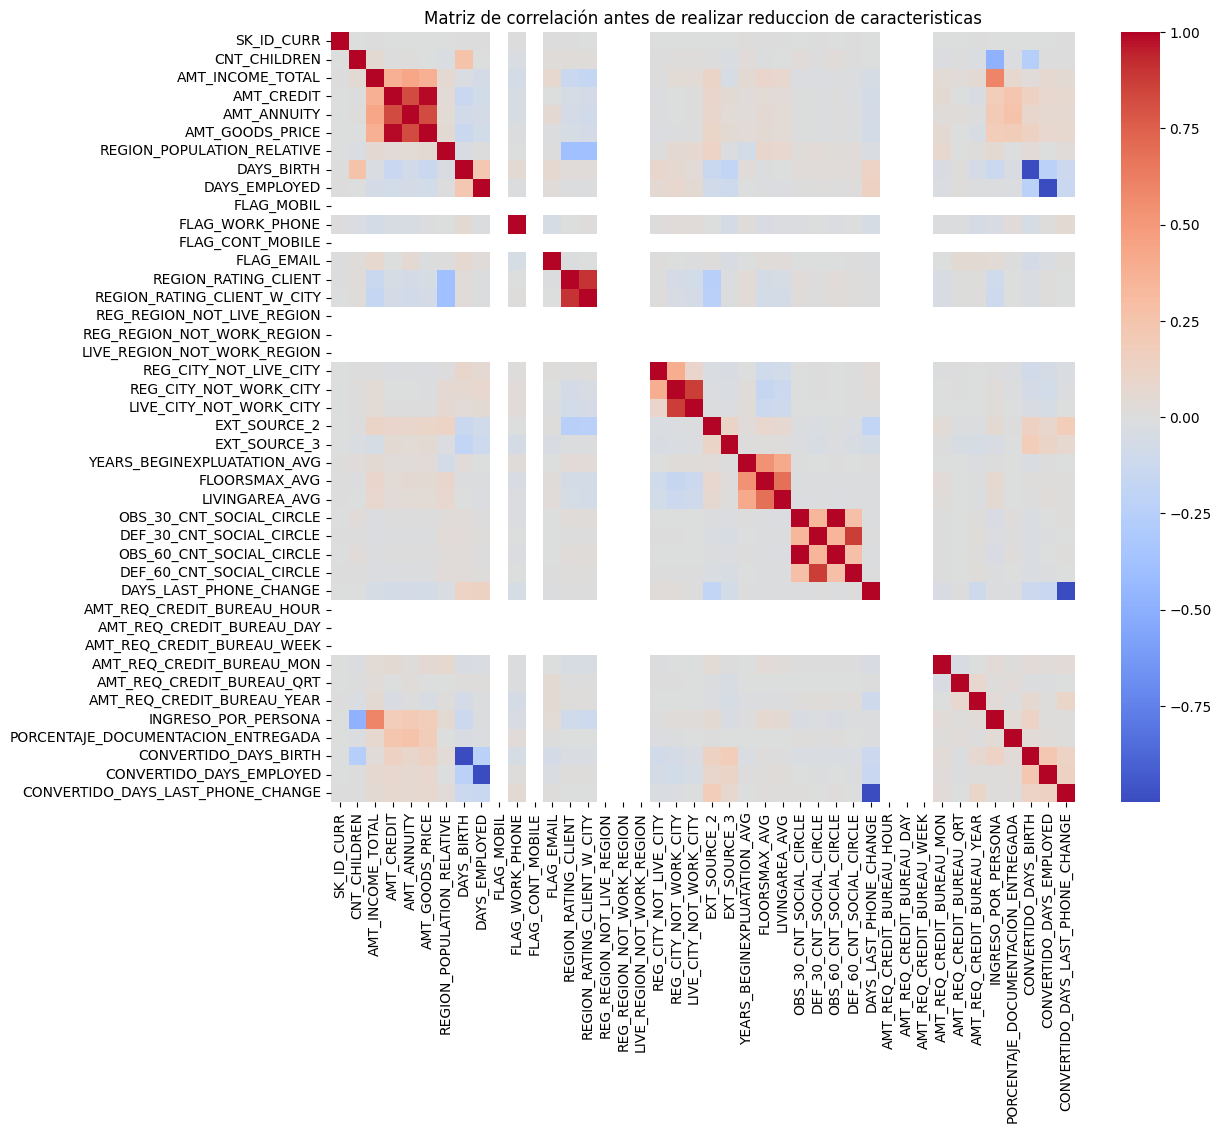

In [113]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Seleccionar solo las columnas numéricas
numericas = [col for col, dtype in zip(df_combinado.columns, df_combinado.dtypes)
             if dtype in (pl.Float64, pl.Float32, pl.Int64, pl.Int32)]

# 2. Crear un DataFrame solo con esas columnas
df_num = df_combinado.select(numericas)

# 3. Calcular la matriz de correlación con Polars
corr_np = pl.DataFrame(df_num).to_numpy()
corr_matrix = np.corrcoef(corr_np, rowvar=False)

# 4. Crear un heatmap con seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, xticklabels=numericas, yticklabels=numericas, cmap="coolwarm", center=0)
plt.title("Matriz de correlación antes de realizar reduccion de caracteristicas")
plt.show()


In [114]:
columnas_no_eliminar = [
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'INGRESO_POR_PERSONA',
    'PORCENTAJE_DOCUMENTACION_ENTREGADA',
    'CONVERTIDO_DAYS_BIRTH',
    'CONVERTIDO_DAYS_EMPLOYED',
    'CONVERTIDO_DAYS_LAST_PHONE_CHANGE'
]
df_sin_corr, columnas_eliminadas = eliminar_variables_correlacionadas_polars(df_combinado, umbral=0.7,columnas_excluidas=columnas_no_eliminar)
df_combinado=df_sin_corr


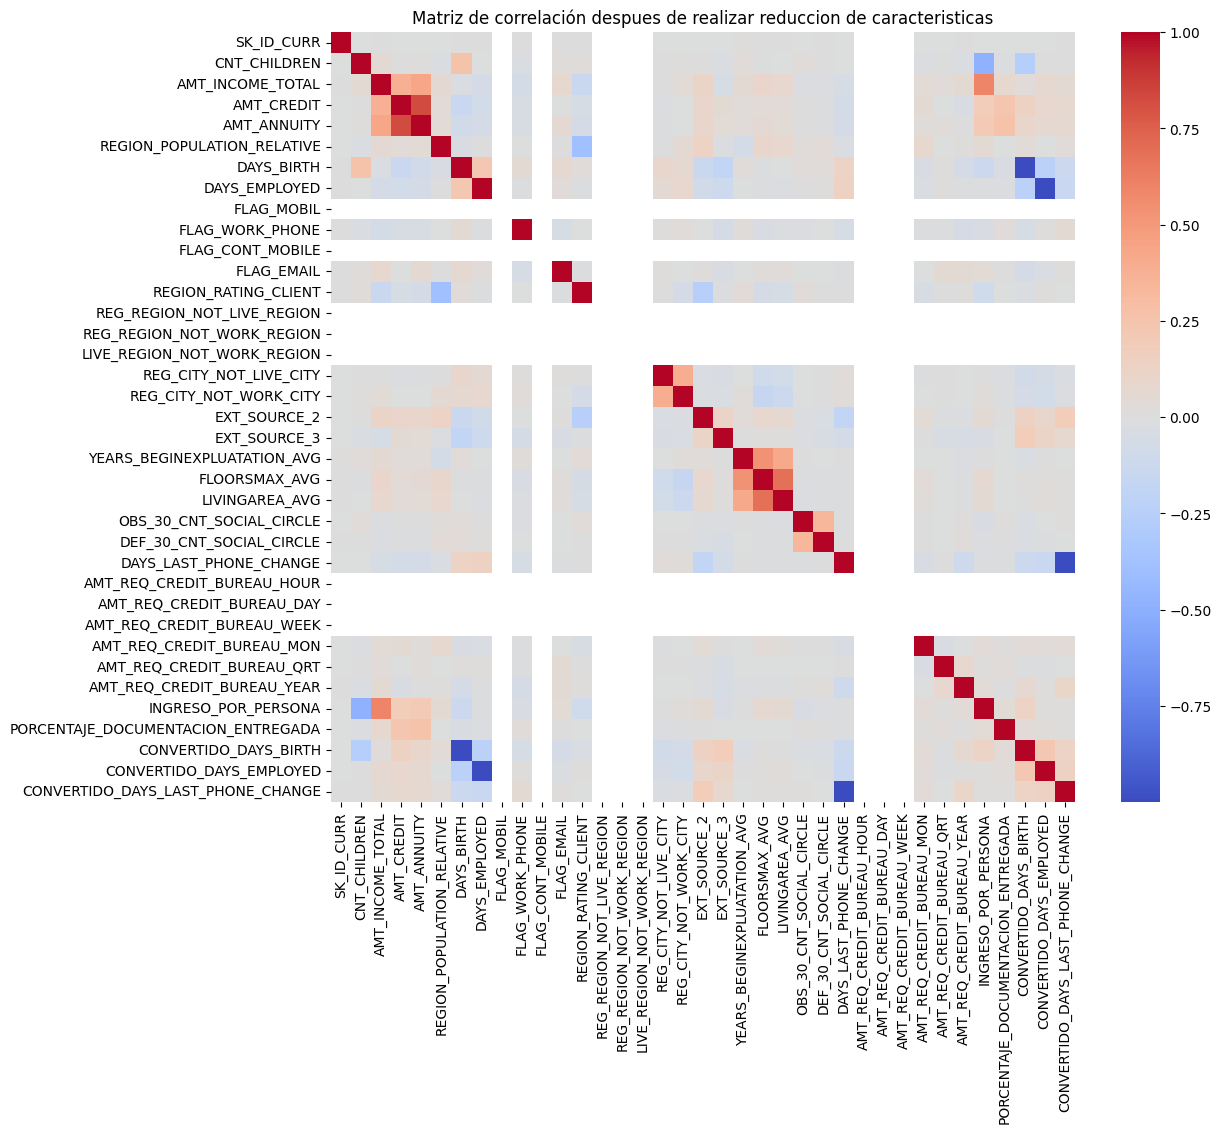

In [115]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Seleccionar solo las columnas numéricas
numericas = [col for col, dtype in zip(df_combinado.columns, df_combinado.dtypes)
             if dtype in (pl.Float64, pl.Float32, pl.Int64, pl.Int32)]

# 2. Crear un DataFrame solo con esas columnas
df_num = df_combinado.select(numericas)

# 3. Calcular la matriz de correlación con Polars
corr_np = pl.DataFrame(df_num).to_numpy()
corr_matrix = np.corrcoef(corr_np, rowvar=False)

# 4. Crear un heatmap con seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, xticklabels=numericas, yticklabels=numericas, cmap="coolwarm", center=0)
plt.title("Matriz de correlación despues de realizar reduccion de caracteristicas")
plt.show()


In [116]:
columnas_eliminadas

['LIVE_CITY_NOT_WORK_CITY',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'REGION_RATING_CLIENT_W_CITY',
 'AMT_GOODS_PRICE',
 'OBS_60_CNT_SOCIAL_CIRCLE']

In [120]:
df_combinado

SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_EMAIL,OCCUPATION_TYPE,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,LIVINGAREA_AVG,HOUSETYPE_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,INGRESO_POR_PERSONA,PORCENTAJE_DOCUMENTACION_ENTREGADA,CONVERTIDO_DAYS_BIRTH,CONVERTIDO_DAYS_EMPLOYED,CONVERTIDO_DAYS_LAST_PHONE_CHANGE
i64,str,str,str,str,i64,f64,f64,f64,str,str,str,str,f64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,str,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
100002,"""Cash loans""","""M""","""N""","""Y""",0,12.2185,12.915581,10.114619,"""Working""","""Secondary / secondary special""","""Single / not married""","""House / apartment""",0.018801,-9461,-637,1,0,1,0,"""Laborers""",2,0,0,0,0,0,"""Business Entity Type 3""",0.262949,0.139376,0.9722,0.0833,0.019,"""block of flats""","""No""",2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,202500.0,0.05,788.0,53.0,94.0
100016,"""Cash loans""","""F""","""N""","""Y""",0,11.119898,11.300549,8.679737,"""Working""","""Secondary / secondary special""","""Married""","""House / apartment""",0.031329,-13439,-2717,1,1,1,0,"""Laborers""",2,0,0,0,0,0,"""Business Entity Type 2""",0.715042,0.176653,0.9811,0.1667,0.0778,"""block of flats""","""No""",0.0,0.0,-2370.0,0.0,0.0,0.0,1.0,0.0,0.0,33750.0,0.05,1120.0,226.0,198.0
100017,"""Cash loans""","""M""","""Y""","""N""",1,12.32386,13.730463,10.27393,"""Working""","""Secondary / secondary special""","""Married""","""House / apartment""",0.016612,-14086,-3028,1,0,1,0,"""Drivers""",2,0,0,0,0,0,"""Self-employed""",0.566907,0.770087,0.9806,0.3333,0.1397,"""block of flats""","""No""",0.0,0.0,-4.0,0.0,0.0,0.0,0.0,0.0,1.0,75000.0,0.05,1174.0,252.0,0.0
100026,"""Cash loans""","""F""","""N""","""N""",1,13.017005,13.117393,10.389687,"""Working""","""Secondary / secondary special""","""Married""","""Rented apartment""",0.020713,-11146,-4306,1,0,1,0,"""Sales staff""",3,0,0,0,0,0,"""Self-employed""",0.457143,0.358951,0.9786,0.1667,0.0873,"""block of flats""","""No""",0.0,0.0,-468.0,0.0,0.0,0.0,0.0,0.0,5.0,150000.0,0.05,929.0,359.0,39.0
100029,"""Cash loans""","""M""","""Y""","""N""",2,11.813037,12.41917,9.449712,"""Working""","""Secondary / secondary special""","""Married""","""House / apartment""",0.026392,-11286,-746,1,0,1,0,"""Drivers""",2,0,0,0,0,1,"""Business Entity Type 3""",0.786179,0.565608,0.9861,0.1667,0.1217,"""block of flats""","""No""",1.0,1.0,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,33750.0,0.05,940.0,62.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
456011,"""Cash loans""","""F""","""Y""","""Y""",1,12.049425,12.686834,10.049124,"""Commercial associate""","""Secondary / secondary special""","""Married""","""House / apartment""",0.02461,-12970,-305,1,0,1,1,"""Sales staff""",2,0,0,0,0,0,"""Business Entity Type 3""",0.554481,0.612704,0.9747,0.1667,0.0601,"""block of flats""","""No""",0.0,0.0,-1239.0,0.0,0.0,0.0,0.0,0.0,0.0,57000.0,0.05,1081.0,25.0,103.0
456111,"""Cash loans""","""F""","""N""","""Y""",1,11.630717,13.151361,9.7818,"""Working""","""Secondary / secondary special""","""Civil marriage""","""House / apartment""",0.020246,-15847,-2191,1,0,1,0,"""Laborers""",3,0,0,0,0,0,"""Business Entity Type 3""",0.387059,0.295583,0.9752,0.1667,0.0526,"""block of flats""","""No""",0.0,0.0,-2019.0,0.0,0.0,0.0,0.0,0.0,0.0,37500.0,0.05,1